# Generate Atari Game frames with Generative Adversarial Neural Networks

## References
* [(Lapan, 2020), Deep Reinforcement Learning Hands-On Second Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998/ref=sr_1_1?keywords=deep+reinforcement+learning+hands-on&qid=1648904999&sprefix=deep+reinfor%2Caps%2C261&sr=8-1)
    * [Github](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter03/03_atari_gan.py)
* [(Goodfellow, 2014) Generative adversarial nets](https://arxiv.org/abs/1406.2661?source=post_page-----b665bbae3317----------------------)

This notebook depics a GAN architecture to generate Atari game frames. For three selected games, we are going to generate frames using a random agent policy and train a GAN to generate realistic frames from those video games.

A GAN architecture contains two different networks competing with each other:
* A Generator $G(z, \theta_g)$, which from random noise can generate fake tensors of the same dimensions of the expected output. In case of images it can be used a Transconvolution, i.e., the inverse of the convolutional process. This network is trained with the aim to fool a *discriminator* making it beleave the fake output is genuine. 
* A Discriminator $D(x, \theta_d)$ that is trained specifically to distinguish between real and fake inputs.

## Requirements
1. Create the conda environment using the provided `environment.yaml` file.
2. **Important:** decode this, download and place them where it can be used :wink: : `aHR0cDovL3d3dy5hdGFyaW1hbmlhLmNvbS9yb21fY29sbGVjdGlvbl9hcmNoaXZlX2F0YXJpXzI2MDBfcm9tcy5odG1sCg==` 

In [1]:
!mkdir -p ./roms
!ale-import-roms roms/

[SUPPORTED]                 air_raid               roms/airraid.bin
[SUPPORTED]                 breakout              roms/breakout.bin
[SUPPORTED]                     pong                  roms/pong.bin



Imported 3 / 3 ROMs


In [2]:
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as tvutils
import gym
import gym.spaces
import numpy as np

logger = gym.logger
logger.set_level(gym.logger.INFO)

IMAGE_SIZE = 64

This is a simple wrapper around gym environments to transform the observation for model training. Image resize and channel transpose.

In [3]:
class InputWrapper(gym.ObservationWrapper):

    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        assert isinstance(self.observation_space, gym.spaces.Box)
        old_space = self.observation_space
        self.observation_space = gym.spaces.Box(
            self.observation(old_space.low),
            self.observation(old_space.high),
            dtype=np.float32
        )

    def observation(self, observation):
        new_obs = cv2.resize(observation, (IMAGE_SIZE, IMAGE_SIZE))
        # W x H X C -> C x W x H
        new_obs = np.transpose(new_obs, [2, 0, 1])
        return new_obs.astype(np.float32)



### Discriminator $D(x, \theta_d)$
First we define the discriminator. It can be of any architecture, in this case since we are dealing with images, we define a convolutional architecture. What is important is that the output should be binary that signals if the input is true or fake, so the last activation should be a $\mathrm{sigmoid(x)}$.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, filters):
        super(Discriminator, self).__init__()
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 2, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 4, out_channels=filters * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 8, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
            # nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

### Generator $G(z, \theta_g)$
The generator can start from a random noise prior $p_g(z)$ and transform it till we obtain a tensor with the same dimensions as the original expected outputs, e.g., images. So we make use of `ConvTranspose` to basically inverse the convolution process.

In [5]:
class Generator(nn.Module):
    def __init__(self, output_shape, latent_vec_size, filters):
        super(Generator, self).__init__()
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_vec_size, out_channels=filters * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(filters * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 8, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 4, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 2, out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters, out_channels=output_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)

This function simply will play the games in the envs with a random policy agent till fills up a buffer for the batch size and returns it as a tensor from which both the Generator and Discriminator will train.

In [6]:
def generate_batch(envs, batch_size):
    batch = [e.reset() for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)

    while True:
        e = next(env_gen)
        obs, reward, is_done, _ = e.step(e.action_space.sample())
        if np.mean(obs) > 0.01:
            batch.append(obs)
        if len(batch) == batch_size:
            batch_np = np.array(batch, dtype=np.float32) * 2.0 / 255.0 - 1.0 # Normalize values
            return torch.tensor(batch_np)
        if is_done:
            e.reset()

### Preparations
Below we do several things:
1. Prepare the environments 
2. Define the input shape, which should be dimensions of a game frame: `C x W x H`. And the `latent_vector_space` which is basically the size of the noise prior to be feed into the generator.
3. Define the Discriminator & Generator networks
4. Define the loss. The training revolves about the discriminator, which output is binary, hence we define a `Binary Cross Entropy Loss`.
5. Define separate optimizers for both networks
6. Define auxiliarly structures.
7. Define labels for the discriminator. The way we train $D$ is by comparing its output testing if its fake or real, so we just need two dummies for that. When we compute the loss of $D$, we always know when we feed a real or fake so we use these dummies to compute the loss.  

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# 1
games = ['ALE/Breakout-v5', 'ALE/AirRaid', 'ALE/Pong']
envs = [InputWrapper(gym.make(env_name)) for env_name in games]

#2
input_shape = envs[0].observation_space.shape
latent_vector_size = 100

#3
net_discriminator = Discriminator(input_shape, filters=64).to(device)
net_generator = Generator(output_shape=input_shape, filters=64, latent_vec_size=latent_vector_size).to(device)

#4
discriminator_loss = nn.BCEWithLogitsLoss()
learing_rate = 1e-3
#5
disc_optimizer = optim.Adam(net_discriminator.parameters(), lr=learing_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(net_generator.parameters(), lr=learing_rate, betas=(0.5, 0.999))

#6
writer = SummaryWriter(log_dir='./tensorboard')

gen_losses = []
disc_losses = []
batch_size = 4096

#7
true_labels_v = torch.ones(batch_size, device=device)
fake_labels_v = torch.zeros(batch_size, device=device)

INFO: Making new env: ALE/Breakout-v5
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/iarai/home/luis.ferro/.conda/envs/gan-pytorch/lib/python3.9/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/iarai/home/luis.ferro/.conda/envs/gan-pytorch/lib/python3.9/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
INFO: Making new env: ALE/AirRaid
/iarai/home/luis.ferro/.conda/envs/gan-pytorch/lib/python3.9/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `ALE/AirRaid-v5` instead of the unversioned environment `ALE/AirRaid`
  logger.warn(
INFO: Making new env: ALE/Pong
/iarai/home/luis.ferro/.conda/envs/gan-pytorch/lib/python3.9/site-packages/gym/envs/registr

### Training
The training proceeds as follows:
1. Generate a batch from the real games
2. Generate fakes from a random prior
3. **Train Discriminator**: Invoke the discriminator on both, the generated and the real images.
4. The total loss should be the sum of the loss produced by the fakes and the real ones. So the gradient for the discriminator update is: 
$$
\nabla_{\theta_d} \frac{1}{m}\sum_{i=1}^m \begin{bmatrix}
\mathrm{log}D(x^{(i)}) + \mathrm{log}(1 - D(G(z^{(i)})))
\end{bmatrix}
$$
Where $x^{(i)}$ correspond to the $i_{th}$ real $x$ example and similarly $z^{(i)}$ correspond to the $i_{th}$ fake $z$ counterpart.
**IMPORTANT** while computing the discriminator loss for the fakes we need to `detach` the output of the generator to avoid computing gradients for this evaluation, otherwise the training can be messed up.
5. **Train Generator**: Invoke again the discriminator on the fake generated image, this time computing the gradients (no `detach`) and calculate the `BCELoss` against true lables, i.e., we are training to make these images 'real' against the discriminator. So the gradient for the generator update is:
$$
\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^m \mathrm{log}(1 - D(G(z^{(i)})))
$$

In [8]:
%%time
from tqdm import tqdm

epochs = 15000
log_img_every = epochs // 1000
with tqdm(total=epochs) as progress:
    for iter_no in range(epochs):
        # 1
        batch_v = generate_batch(envs, batch_size)
        # 2 input tensor shape: batch x latent vec size x 'width' x 'height' as a single value
        gen_input_v = torch.FloatTensor(batch_size, latent_vector_size, 1, 1)
        gen_input_v.normal_(0., .5) # fill tensor with gaussian random with mu=0.0 and sigma=1
        gen_input_v = gen_input_v.to(device)
        batch_v = batch_v.to(device)
        gen_output_v = net_generator(gen_input_v)

        # 3 train discriminator
        disc_optimizer.zero_grad()
        dis_output_true_v = net_discriminator(batch_v)
        dis_output_fake_v = net_discriminator(gen_output_v.detach())
        dis_loss = discriminator_loss(dis_output_true_v, true_labels_v) + discriminator_loss(dis_output_fake_v, fake_labels_v)
        dis_loss.backward()
        disc_optimizer.step()
        
        writer.add_scalar('losses/discriminator', dis_loss.item(), global_step=iter_no)
        disc_losses.append(dis_loss.item())

        # 4 train generator
        gen_optimizer.zero_grad()
        dis_output_v = net_discriminator(gen_output_v)
        gen_loss_v = discriminator_loss(dis_output_v, true_labels_v)
        gen_loss_v.backward()
        gen_optimizer.step()
        
        writer.add_scalar('losses/generator', gen_loss_v.item(), global_step=iter_no)
        gen_losses.append(gen_loss_v.item())

        # log images every n
        if iter_no % log_img_every == 0:
            indices = np.random.randint(0, batch_size, size=16)
            writer.add_image("fake", tvutils.make_grid(
                gen_output_v.data[indices], normalize=True
            ), global_step=iter_no)
            writer.add_image("real", tvutils.make_grid(
                batch_v.data[indices], normalize=True
            ), global_step=iter_no)

        progress.set_postfix({
            'dis_loss': f'{dis_loss.item():.4f}',
            'gen_loss': f'{gen_loss_v.item():.4f}'
            })
        writer.flush()
        progress.update()
        


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:10:47<00:00,  2.68s/it, dis_loss=0.0000, gen_loss=13.3286]

CPU times: user 4d 15h 51min 58s, sys: 4h 10min 47s, total: 4d 20h 2min 46s
Wall time: 11h 10min 47s


Now let's observe the behavior of the losses.

/iarai/home/luis.ferro/.conda/envs/gan-pytorch/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


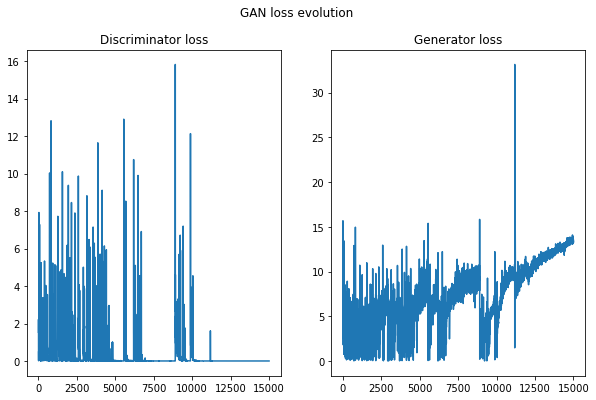

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle("GAN loss evolution")
ax = axes.ravel()
ax[0].plot(disc_losses)
ax[0].set_title("Discriminator loss")
ax[1].plot(gen_losses)
ax[1].set_title("Generator loss")
plt.show()

We can observe that the losses tend to be inverse to each other. Whenever the discriminator loss tends to zero, means the discriminator is successfully able to discern fakes vs real images, and when the generator loss decreases, it means the discrimenator generates 'credible' images that the discriminator has a harder time to label as fake (hence its loss increases).

Now let's observe the results

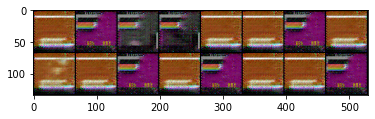

In [10]:
net_generator.eval()
with torch.no_grad():
    gen_input_v = torch.normal(.0, 1., size=(16, latent_vector_size, 1, 1)).to(device)
    gen_output_v = net_generator(gen_input_v)
    generated_images = tvutils.make_grid(gen_output_v.data, normalize=True).cpu().numpy()
    generated_images = np.transpose(generated_images, [1, 2, 0])
    plt.imshow(generated_images)
    plt.show()

Good images start to emerge after 30K epochs (as per book)

In [11]:
torch.save(net_discriminator.state_dict(), './checkpoints/atari-discriminator-v1.cpt')
torch.save(net_generator.state_dict(), './checkpoints/atari-generator-v1.cpt')